# Problems to Try

## Problem 1: Projecting Particle Density

Returning to the overview of discrete 3D notebook, we outlined a way to compute the per-pixel contribution of SPH particles being projected.  We're going to implemnet this in python.

This will be slow!  (It really will, believe me!)  Here are the steps to complete:

1. Write a function that takes the number of pixels on a side and returns a numpy array that includes the projected density in each pixel, computing the full function for each particle.  This should be $O(N^2)$ and will have lots of execution time.  Try running it on just a couple hundred of the SPH particles in the example dataset.
1. Speed this up by eliminating all of the particles that are smaller than one pixel, and depositing them in a single pass.
1. Implement an interpolation table for the impact parameter-dependent function.
1. For a fixed number of particles, compare runtimes for 64x64, 128x128, 256x256, 512x512 and 1024x1024 pixels.  Do the same for varying the number of particles (and varying the subsampling method for particles) with a fixed pixel buffer resolution.
1. For this problem, what are ways it could be sped up inside a Jupyter notebook?  (This is an intentionally vaguely-worded question!)  If you feel comfortable doing any of these things, do it!

In [4]:
import numpy as np
import h5py
import itertools

In [3]:
part_dm = {}
part_gas = {}
with h5py.File("GadgetDiskGalaxy/snapshot_200.hdf5", "r") as f:
    part_gas["Coordinates"] = f["/PartType0/Coordinates"][()]
    part_gas["Masses"] = f["/PartType0/Masses"][()]
    part_gas["Density"] = f["/PartType0/Density"][()]
    part_gas["Velocities"] = f["/PartType0/Velocities"][()]
    part_gas["SmoothingLength"] = f["/PartType0/SmoothingLength"][()]
    part_dm["Coordinates"] = f["/PartType1/Coordinates"][()]
    part_dm["Velocities"] = f["/PartType1/Velocities"][()]

In [7]:
for i in range(2):
    print(np.min(part_gas["Coordinates"][:,i]), np.max(part_gas["Coordinates"][:,i]))

24345.633 38353.496
23540.342 37534.652


In [42]:
def projected_density(coordinates, num_pix, Aj=None):
    projected_array = np.zeros((num_pix, num_pix))

    # Define bins
    min_edge = coordinates[:,0:2].min() - 1
    max_edge = coordinates[:,0:2].max() + 1
    bin_ids = (coordinates[:,0:2] - min_edge) // ((max_edge - min_edge) / num_pix) - 1

    # Count particles in each bin
    bins, counts = np.unique(bin_ids, return_counts=True, axis=0)
    
    # Fill in projected_array
    for idx, bin_id in enumerate(bins.astype(int)):
        projected_array[bin_id[1], bin_id[0]] = counts[idx].astype(float)
    
    return projected_array
        
            

In [43]:
arr = projected_density(part_gas["Coordinates"], 64)

In [39]:
import matplotlib.pyplot as plt

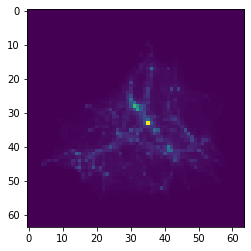

In [44]:
plt.figure()
plt.imshow(arr)
plt.show()
plt.close()

In [47]:
import time

In [49]:
start = time.time()
arr = projected_density(part_gas["Coordinates"][:1000], 64)
print(time.time() - start)

0.008865118026733398


In [50]:
start = time.time()
arr = projected_density(part_gas["Coordinates"][:1000], 128)
print(time.time() - start)

0.0029680728912353516


In [51]:
%%timeit
arr = projected_density(part_gas["Coordinates"][:1000], 256)

15.3 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%%timeit
arr = projected_density(part_gas["Coordinates"][:1000], 512)

17.6 ms ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
start = time.time()
arr = projected_density(part_gas["Coordinates"][:1000], 1024)
print(time.time() - start)

0.0064029693603515625


## Problem 2: Rotations with Quaternions

Quaternions are a more effective way of rotating data points, but they are also somewhat conceptually more challenging.

1. Convert our rotation example to use quaternions.
1. Demonstrate the specific values where the YPR rotations would result in gimble lock or other singularities.  Demonstrate you can rotate smoothly through this with quaternions.
1. **BONUS CHALLENGE**: if you have a USB gamepad, plug it in to your computer and see if you can get the `ipywidgets.Controller` widget to show up.  Use your controller to rotate.  (This one might be pretty hard, but is kind of worth it.)

## Problem 3: Stepping through a Gridded Volume

We saw in a previous notebook how to compute axis-aligned 

In [Amanatides & Woo (1987)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf) they demonstrate a method of traversing a grid.  This is useful for when you want to accumulate values that cannot be separated or arbitrarily ordered, or where the traversal distance is important.  For the former, this would be any case where emission/absorption are computed, and the latter is any case that an accurate path length is required (for instance, computing the column density off-axis).

We'll use the term 'ray' to refer to individual paths traversed through a grid.  Again, we'll start this out slowly, and speed it up as we move along.

1. Generate a distribution of values that approximates a sphere, along a regular grid.  Make it have a hard cut-off at some radius, but make it constant within that radius (at first).
1. Choose a random position *outside* of the sphere and walk a line that passes through the origin all the way out the other end.  Write this in pure python.
1. Walk the ray through the origin of the sphere, accumulating $vdt$ where $v$ is the value and $dt$ is the local distance across a cell.  Verify that the returned value is $2r$.
1. Modify your grid so that it is now composed of *irregular* cell widths, as we did in the previous notebook.  Trace the ray again and make sure you get the same results.
1. Construct a plane of rays with the same orientation (but different positions) and walk each one in turn.  (Start with the regular grid, then do the irregular grid.)  Verify that you get a nice looking sphere with limb-darkening as your impact parameter increases.
1. **BONUS**: Change the value distribution function to be something radially-specified, or from a yt-loaded galaxy simulation, and render isosurfaces in R, G, B.  Specify a width in value-space and add R, G, B to them based on what they pass through.  This is volume rendering!
1. **BONUS**: How would you speed this up?  What would happen if you needed to pass through multiple grids?  What if those grids overlapped?

## Problem 4: Displaying Streamlines

Building on Problem 3, we're going to construct "streamlines."  Streamlines are the motion of "test particles" through a field.  They can be used, for example, to demonstrate field flow.  To start out, use `yt` to load a dataset (`IsolatedGalaxy` is a good one; try grabbing it from 0.45 to 0.55 in all three dimensions) and regularize it to a grid using `ds.r[]` notation.  For examples:

```python
import yt
ds = yt.load_sample("IsolatedGalaxy")
reg = ds.r[0.45:0.55:256j, 0.45:0.55:256j, 0.45:0.55:256j]
x_vel = reg["velocity_x"]
y_vel = reg["velocity_y"]
z_vel = reg["velocity_z"]
```

This grids it to $256^3$ zones.

1. Randomly choose a point in the grid.  Using euler integration (i.e., $ \mathbf{\vec{x}}' = \mathbf{\vec{x}} + \mathbf{\vec{v}}dt$ ) follow your test particle until you have integrated it for a total traversal of 0.5 units.  You'll need to apply a (large) scalar factor to the velocities so that it does not pass out of the domain on the first timestep.
1. What, quantitatively and qualitatively, happens if you change your integration timestep $dt$?
1. Using matplotlib, plot this streamline projected along all three axes.
1. Using matplotlib, plot this streamline in 3D using the [line plots in 3D](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#line-plots) functionality.
1. How does this visualization scale for computing the streamlines, for visualizing the streamlines in matplotlib, and how does it scale as you change either the $dt$ or the number of grid cells?
1. **BONUS CHALLENGE**: Using `pythreejs`, display a collection of streamlines (from randomly generated locations) in 3D.  See if you can overlay the box on them.

## **BONUS PROBLEM 5**: Rendering SPH in pythreejs

(I think this one might be the hardest?)

In pythreejs, you can define a custom "material" that defines colors, sizes, etc.  Let's use our material to change the color and sizes of our particles.

1. Make a custom material.  In the appendix just below, you can see examples of vertex and fragment shaders that will get you started.  Add a new attribute to your `BufferGeometry` that passes in sizes that can then be used.
2. Instead of using the `ParticleMaterial`, use the new material that uses these shaders.  Render this.  Supply the smoothing length (scaled downwards since we're rescaling!) to the `BufferGeometry`.
3. Add a `uniform float scale` to change the scale.  (You'll probably want to avoid making this really big, as that will slow down rendering considerably.)  Link this value to an `ipywidgets` slider.
4. **BONUS CHALLENGE**: Change the color intensity based on values for the density.  This will require adding a new attribute, a new attribute, and passing that attribute as a `varying` from the vertex shader to the fragment shader.
5. **RIDICULOUS CHALLENGE**: Using the 3D projection equation from the SPLASH paper, make the output of the fragment shader equal to the projected output.  Scale this.  This will produce an in-browser SPH volume renderer.

### Appendix for Bonus Problem 5

You can create a custom shader in pythreejs by constructing one.  You will need to specify the fragment shader and vertex shader, which are written in a language called GLSL.  These can be supplied as string literals.'   Note that you can add new `uniform` variables to the dictionary passed in here, but they have to be specified themselves as `dict` objects, with the key `value`.  (When I write it like that, it sounds odd, right?!)  You'd do this with something like `myVariable = dict(value = 1.0))`.

```python
pm = pythreejs.ShaderMaterial(vertexShader = vertex_shader,
                              fragmentShader = fragment_shader,
                              blending = "MultiplyBlending",
                              depthTest=True,
                              transparent=True,
                              uniforms = dict(
                                  **pythreejs.UniformsLib['common']
                              )
```

Your vertex shader might look something like this:

```glsl
attribute float size;
attribute float value;
varying float vValue;

void main() {
    vValue = value;
    vec4 mvPosition = modelViewMatrix * vec4( position, 1.0 );
    gl_PointSize = size * ( 1.0 / -mvPosition.z );
    gl_Position = projectionMatrix * mvPosition;
}
```

Your fragment shader might look something like this:

```glsl
varying float vValue;
void main() {
    gl_FragColor = vec4(1.0, 0.0, 0.0, 1.0);
}
```